In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
data = pd.read_csv("filtered_data.csv")
X_data = data.drop(columns=["name", "Label"], errors='ignore')
y_data = data["Label"]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

Hyperparameter Tuning

In [3]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Initialize XGBoost classifier
xgb = XGBClassifier()

# Define parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Apply GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best parameters
print(f"Best Parameters: {grid_search.best_params_}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Get best estimator
best_xgb = grid_search.best_estimator_

# Predict
y_pred = best_xgb.predict(X_test)

# Metrics
print(" Accuracy:", accuracy_score(y_test, y_pred))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(" Classification Report:\n", classification_report(y_test, y_pred))


 Accuracy: 0.9790575916230366
 Confusion Matrix:
 [[ 80   1]
 [  3 107]]
 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98        81
           1       0.99      0.97      0.98       110

    accuracy                           0.98       191
   macro avg       0.98      0.98      0.98       191
weighted avg       0.98      0.98      0.98       191



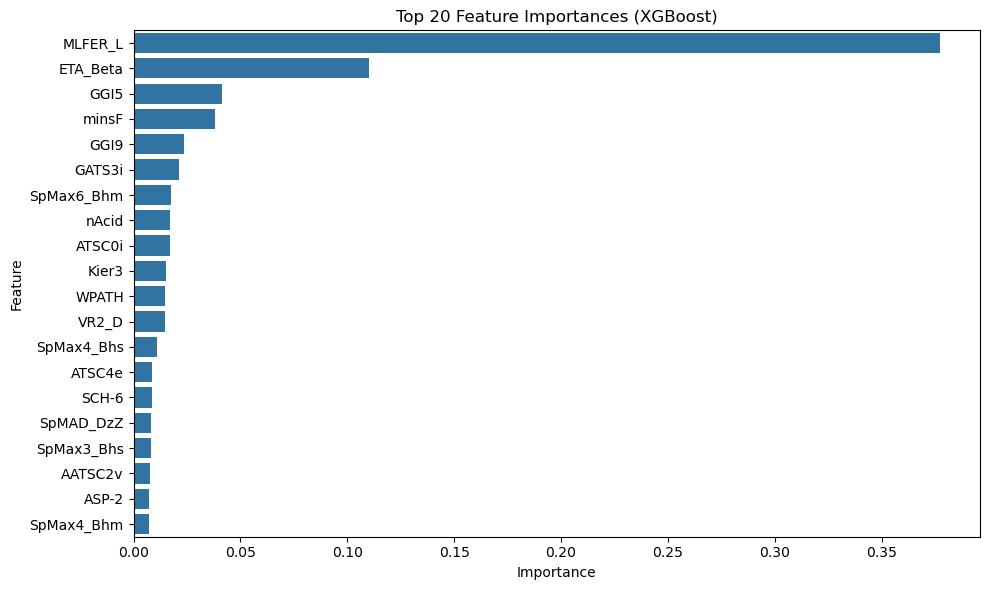

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importance
importances = best_xgb.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


In [7]:
import joblib
joblib.dump(best_xgb, "xgboost_final_model.pkl")


['xgboost_final_model.pkl']

In [9]:
import pandas as pd
import numpy as np

# Predict probabilities for test set
y_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # Probability of class 1 (active)

# Add to a DataFrame with original features and actual/predicted classes
test_results = X_test.copy()
test_results['True_Label'] = y_test.values
test_results['Predicted_Label'] = grid_search.best_estimator_.predict(X_test)
test_results['Probability'] = y_proba

# Filter for predicted actives only (Predicted_Label == 1)
predicted_actives = test_results[test_results['Predicted_Label'] == 1]

# Sort by probability (confidence)
top_actives = predicted_actives.sort_values(by='Probability', ascending=False)

# View top 10 predicted actives
top_actives.head(10)


,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nB,nN,nO,nS,...,VE3_D,VR1_D,VR2_D,TopoPSA,SRW5,WPATH,XLogP,True_Label,Predicted_Label,Probability
94,1,0.0567,0.003215,67.2412,78.789583,16,0,2,4,0,...,-11.549400,771.120535,20.292646,82.89,0.000000,5324,4.676,1,1,0.999853
85,1,0.3213,0.103234,71.9843,80.412583,16,0,2,4,0,...,-9.555877,978.400421,25.747380,82.89,0.000000,5382,4.813,1,1,0.999845
89,1,-0.4230,0.178929,66.3687,78.899376,16,0,2,4,0,...,-8.374921,627.711136,16.965166,82.89,0.000000,5008,4.717,1,1,0.999844
104,1,-0.1584,0.025091,71.1118,80.522376,16,0,2,4,0,...,-9.906736,577.263941,15.601728,82.89,0.000000,4950,4.854,1,1,0.999832
114,1,-0.0983,0.009663,66.2952,75.805790,16,0,2,4,0,...,-6.653215,567.039780,15.751105,82.89,0.000000,4740,4.708,1,1,0.999830
533,0,0.9336,0.871609,106.8976,82.494204,11,0,4,12,2,...,-4.928970,543.135567,12.631060,264.08,2.397895,6953,2.722,1,1,0.999828
271,1,0.1812,0.032833,69.2251,53.696688,10,0,4,4,1,...,-6.141052,394.230239,14.601120,152.42,3.044522,2181,1.107,1,1,0.999821
93,1,-0.0139,0.000193,74.0953,81.392376,16,0,2,4,0,...,-8.303674,630.068252,17.028872,82.89,0.000000,5008,5.192,1,1,0.999817
92,1,0.0567,0.003215,67.2412,78.789583,16,0,2,4,0,...,-9.605157,996.134521,26.214066,82.89,0.000000,5380,4.676,1,1,0.999816
113,1,-1.3824,1.911030,64.6237,79.118962,16,0,2,4,0,...,-7.198095,671.182355,19.176639,82.89,0.000000,4272,6.065,1,1,0.999814


In [10]:
top_actives.to_csv("top_predicted_actives.csv", index=False)
